This notebook  borrows a couple of ideas from the [**Original TensorFlow NMT tutorial**](https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb) . But the main focus of this noteobook is to illustrate the power of Char Ngram based Langauge Models learned using an Encoder-Decoder Model and how it is used to solve real world problems. <span style="color:red">  At the first blush smart compose will look very similar to predictive keyboard. But there is a lot more to smart compose. </span>  Please look at the accompanying post for more details


**This notebook  is tested in tensorflow-gpu=1.13.1**





In [2]:
# Start by importing all the things we'll need.
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, CuDNNLSTM, Flatten, TimeDistributed, Dropout, LSTMCell, RNN, Bidirectional, Concatenate, Layer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import tf_utils
from tensorflow.keras import backend as K

import unicodedata
import re
import numpy as np
import os
import time
import shutil

import pandas as pd
import numpy as np
import string, os 
tf.__version__

'1.13.1'

In [0]:
file = open("./sample_data/dataset.txt", 'r')
corpus = [line for line in file]

In [9]:
corpus[40:50]

['I will be there\n',
 'Resignation Please accept my resignation.\n',
 'I need a response on this issue\n',
 'Here is the revised version.\n',
 'Please accept our offer\n',
 'this sounds acceptable to us.\n',
 'Great. Thanks.\n',
 'please find attached a very rough draft\n',
 'Have a nice weekend\n',
 'Christmas Party Remembered: Merry Christmas Everyone!\n']

In [0]:
def clean_special_chars(text, punct):
    for p in punct:
        text = text.replace(p, '')
    return text

      
def preprocess(data):
    output = []
    punct = '#$%&*+-/<=>@[\\]^_`{|}~\t\n'
    for line in data:
         pline= clean_special_chars(line.lower(), punct)
         output.append(pline)
    return output  


def generate_dataset():
  
    processed_corpus = preprocess(corpus)    
    output = []
    for line in processed_corpus:
        token_list = line
        for i in range(1, len(token_list)):
            data = []
            x_ngram = '<start> '+ token_list[:i+1] + ' <end>'
            y_ngram = '<start> '+ token_list[i+1:] + ' <end>'
            data.append(x_ngram)
            data.append(y_ngram)
            output.append(data)
    print("Dataset prepared with prefix and suffixes for teacher forcing technique")
    dummy_df = pd.DataFrame(output, columns=['input','output'])
    return output, dummy_df            
    

In [0]:
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
        self.vocab = sorted(self.vocab)
        self.word2idx["<pad>"] = 0
        self.idx2word[0] = "<pad>"
        for i,word in enumerate(self.vocab):
            self.word2idx[word] = i + 1
            self.idx2word[i+1] = word

def max_length(t):
    return max(len(i) for i in t)

def load_dataset():
    pairs,df = generate_dataset()
    out_lang = LanguageIndex(sp for en, sp in pairs)
    in_lang = LanguageIndex(en for en, sp in pairs)
    input_data = [[in_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    output_data = [[out_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]

    max_length_in, max_length_out = max_length(input_data), max_length(output_data)
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_data, maxlen=max_length_in, padding="post")
    output_data = tf.keras.preprocessing.sequence.pad_sequences(output_data, maxlen=max_length_out, padding="post")
    return input_data, output_data, in_lang, out_lang, max_length_in, max_length_out, df

In [60]:
input_data, teacher_data, input_lang, target_lang, len_input, len_target, df = load_dataset()


target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))

# Shuffle all of the data in unison. This training set has the longest (e.g. most complicated) data at the end,
# so a simple Keras validation split will be problematic if not shuffled.

p = np.random.permutation(len(input_data))
input_data = input_data[p]
teacher_data = teacher_data[p]
target_data = target_data[p]



Dataset prepared with prefix and suffixes for teacher forcing technique


In [61]:
pd.set_option('display.max_colwidth', -1)
BUFFER_SIZE = len(input_data)
BATCH_SIZE = 128
embedding_dim = 300
units = 128
vocab_in_size = len(input_lang.word2idx)
vocab_out_size = len(target_lang.word2idx)
df.iloc[60:65]

,input,output
60,<start> thank you fo <end>,<start> r your cooperation <end>
61,<start> thank you for <end>,<start> your cooperation <end>
62,<start> thank you for <end>,<start> your cooperation <end>
63,<start> thank you for y <end>,<start> our cooperation <end>
64,<start> thank you for yo <end>,<start> ur cooperation <end>


In [62]:
# Create the Encoder layers first.
encoder_inputs = Input(shape=(len_input,))
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim)

# Use this if you dont need Bidirectional LSTM
# encoder_lstm = CuDNNLSTM(units=units, return_sequences=True, return_state=True)
# encoder_out, state_h, state_c = encoder_lstm(encoder_emb(encoder_inputs))

encoder_lstm = Bidirectional(CuDNNLSTM(units=units, return_sequences=True, return_state=True))
encoder_out, fstate_h, fstate_c, bstate_h, bstate_c = encoder_lstm(encoder_emb(encoder_inputs))
state_h = Concatenate()([fstate_h,bstate_h])
state_c = Concatenate()([bstate_h,bstate_c])
encoder_states = [state_h, state_c]


# Now create the Decoder layers.
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = CuDNNLSTM(units=units*2, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)
# Two dense layers added to this model to improve inference capabilities.
decoder_d1 = Dense(units, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
decoder_out = decoder_d2(Dropout(rate=.2)(decoder_d1(Dropout(rate=.2)(decoder_lstm_out))))


# Finally, create a training model which combines the encoder and the decoder.
# Note that this model has three inputs:
model = Model(inputs = [encoder_inputs, decoder_inputs], outputs= decoder_out)

# We'll use sparse_categorical_crossentropy so we don't have to expand decoder_out into a massive one-hot array.
# Adam is used because it's, well, the best.

model.compile(optimizer=tf.train.AdamOptimizer(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 16, 300)      152400      input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 16, 256), (N 440320      embedding_4[0][0]                
__________________________________________________________________________________________________
embedding_

In [63]:
# Note, we use 20% of our data for validation.
epochs = 10
history = model.fit([input_data, teacher_data], target_data,
                 batch_size= BATCH_SIZE,
                 epochs=epochs,
                 validation_split=0.2)


Train on 118120 samples, validate on 29531 samples
Epoch 1/10
118120/118120 [==============================] - 15s 130us/sample - loss: 0.6460 - sparse_categorical_accuracy: 0.8711 - val_loss: 0.1746 - val_sparse_categorical_accuracy: 0.9520
Epoch 2/10
118120/118120 [==============================] - 14s 119us/sample - loss: 0.1022 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.0233 - val_sparse_categorical_accuracy: 0.9916
Epoch 3/10
118120/118120 [==============================] - 14s 120us/sample - loss: 0.0291 - sparse_categorical_accuracy: 0.9888 - val_loss: 0.0153 - val_sparse_categorical_accuracy: 0.9918
Epoch 4/10
118120/118120 [==============================] - 14s 119us/sample - loss: 0.0207 - sparse_categorical_accuracy: 0.9907 - val_loss: 0.0148 - val_sparse_categorical_accuracy: 0.9923
Epoch 5/10
118120/118120 [==============================] - 14s 119us/sample - loss: 0.0182 - sparse_categorical_accuracy: 0.9912 - val_loss: 0.0141 - val_sparse_categorical_accuracy: 0

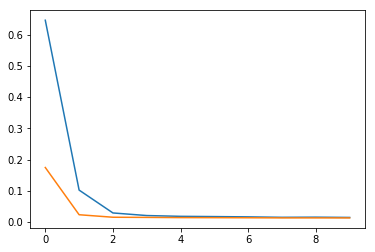

In [64]:
# Plot the results of the training.
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.show()

In [0]:
# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_out, state_h, state_c])

# Generate a new set of tensors for our new inference decoder. Note that we are using new tensors, 
# this does not preclude using the same underlying layers that we trained on. (e.g. weights/biases).

inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")
# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units*2,), name="state_input_h")
state_input_c = Input(shape=(units*2,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))
inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])

In [0]:
# Converts the given sentence (just a string) into a vector of word IDs
# Output is 1-D: [timesteps/words]

def sentence_to_vector(sentence, lang):

    pre = sentence
    vec = np.zeros(len_input)
    sentence_list = [lang.word2idx[s] for s in pre.split(' ')]
    for i,w in enumerate(sentence_list):
        vec[i] = w
    return vec

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
def translate(input_sentence, infenc_model, infmodel):
    sv = sentence_to_vector(input_sentence, input_lang)
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vec = target_lang.word2idx["<start>"]
    stop_vec = target_lang.word2idx["<end>"]
    
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "<start>"
    output_sentence = ""

    while cur_word != "<end>" and i < (len_target-1):
        i += 1
        if cur_word != "<start>":
            output_sentence = output_sentence + " " + cur_word
        x_in = [cur_vec, sh, sc]
        [nvec, sh, sc] = infmodel.predict(x=x_in)
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = target_lang.idx2word[np.argmax(nvec[0,0])]
    return output_sentence

In [73]:
#Note that only words that we've trained the model on will be available, otherwise you'll get an error.


test = [
    'hi there',
    'hell',
    'presentation please fin',
    'resignation please find at',
    'resignation please ',
    'have a nice we',
    'let me ',
    'promotion congrats ',
    'christmas Merry ',
    'please rev',
    'please ca',
    'thanks fo',
    'Let me kno',
    'Let me know if y',
    'this soun',
    'is this call going t'
]
  

import pandas as pd
output = []  
for t in test:  
  output.append({"Input seq":t.lower(), "Pred. Seq":translate(t.lower(), encoder_model, inf_model)})

results_df = pd.DataFrame.from_dict(output) 
results_df.head(len(test))

,Input seq,Pred. Seq
0,hi there,", how are you today?"
1,hell,"o, how are you?"
2,presentation please fin,d attached the presentation
3,resignation please find at,tached my resignation letter.
4,resignation please,accept my resignation.
5,have a nice we,ekend
6,let me,know if you need anything else.
7,promotion congrats,on your promotion
8,christmas merry,everyone!let me know when you are leaving today
9,please rev,iew.


In [0]:
# This is to save the model for the web app to use for generation
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = inf_model.to_json()


with open("./sample_data/model_num.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
inf_model.save_weights("./sample_data/model_num.h5")